In [22]:
import numpy as np
import pandas as pd
import scipy

from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm
import plotly.express as px

%matplotlib inline

In [23]:
btc5min_data = pd.read_csv('BINANCE_BTCUSDT, 5.csv')
btc5min_data['price'] = pd.to_numeric(btc5min_data.open, errors='coerce')
btc5min_data.dropna(inplace=True)

In [24]:
btc5min_data.head(3)

time      open      high       low     close      Volume   Volume MA  \
0  1617109200  59112.81  59265.18  59109.16  59141.89  263.902903  234.711945   
1  1617109500  59141.90  59142.05  58937.84  58955.53  352.315466  245.689359   
2  1617109800  58955.53  59058.98  58900.00  58902.11  319.323272  253.464058   

      price  
0  59112.81  
1  59141.90  
2  58955.53

# Convert the timestamps

In [25]:
btc5min_data['time'] = pd.to_datetime(btc5min_data['time'],unit='s')

In [26]:
btc5min_data.tail(3)

time      open      high       low     close      Volume  \
3879 2021-04-13 00:20:00  60221.44  60279.95  60200.00  60208.98  207.170942   
3880 2021-04-13 00:25:00  60208.99  60363.03  60200.02  60315.36  305.219338   
3881 2021-04-13 00:30:00  60315.36  60333.02  60227.40  60234.20  149.524449   

       Volume MA     price  
3879  165.507511  60221.44  
3880  174.437759  60208.99  
3881  175.921037  60315.36

# Visualization Functions

In [27]:
def ilinechart(df, x, y, groups=None, title=""):
    fig = px.line(df, x=x, y=y, color=groups, title=title, template="none")
    #if groups != None:
    #    for item in range(len(fig.data)-1):
    #        fig.data[item].update(name=fig.data[item]['name'].split('=')[1])
    fig.show()

def iscatter(df, x, y, color=None, size=None, title=""):
    fig = px.scatter(df, x=x, y=y, color=color, size=size, title=title, template='none')
    fig.update_traces(marker_line_color='black', marker_line_width=1)
    fig.show()

def results(y_train, y_test, y_train_pred, y_test_pred, title="", scores=True, scatter=True, line=False):
    if scores==True:
        print('Train')
        print(f'R-squared: {r2_score(y_train, y_train_pred):.4f}')
        print(f'MAE: {mean_absolute_error(y_train, y_train_pred):.2f}')
        print(f'RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.2f}')
        print('\nTest')
        print(f'R-squared: {r2_score(y_test, y_test_pred):.4f}')
        print(f'MAE: {mean_absolute_error(y_test, y_test_pred):.2f}')
        print(f'RMSE: {mean_squared_error(y_test, y_test_pred, squared=False):.2f}')
    train_results = pd.DataFrame({'price': y_train, 'Predicted': y_train_pred})
    train_results['Set'] = 'Train'
    test_results = pd.DataFrame({'price': y_test, 'Predicted': y_test_pred})
    test_results['Set'] = 'Test'
    results = pd.concat([train_results, test_results])
    if scatter==True:
        iscatter(results, x='price', y='Predicted', color='Set', title=title)
    if line==True:
        melted = results.reset_index().melt(id_vars=['time', 'Set'], value_vars=['price', 'Predicted'])
        melted['variable'] = melted['Set'] + ' ' + melted['variable']
        ilinechart(melted, x='time', y='value', groups='variable', title=title)

In [28]:
btc5min_data.head(1)

time      open      high       low     close      Volume  \
0 2021-03-30 13:00:00  59112.81  59265.18  59109.16  59141.89  263.902903   

    Volume MA     price  
0  234.711945  59112.81

# Visualization

In [29]:
ilinechart(btc5min_data, x='time', y='price',title='BTC/USDT 5 Minute')

In [30]:
# Using prior week of closing prices to predict the next week
history = 5
future = 5

shifts = [x + future for x in list(range(1, history + 1))]
print(shifts)

[6, 7, 8, 9, 10]


In [31]:
for shift in shifts:
    btc5min_data['t-' + str(shift)] = btc5min_data['price'].shift(shift)

btc5min_data.head(15)

time      open      high       low     close      Volume  \
0  2021-03-30 13:00:00  59112.81  59265.18  59109.16  59141.89  263.902903   
1  2021-03-30 13:05:00  59141.90  59142.05  58937.84  58955.53  352.315466   
2  2021-03-30 13:10:00  58955.53  59058.98  58900.00  58902.11  319.323272   
3  2021-03-30 13:15:00  58902.10  59050.00  58835.00  59010.35  497.029922   
4  2021-03-30 13:20:00  59010.36  59152.10  59001.00  59081.89  305.367655   
5  2021-03-30 13:25:00  59089.51  59133.41  59060.19  59095.74  190.019904   
6  2021-03-30 13:30:00  59095.74  59111.33  58920.22  58939.98  202.669877   
7  2021-03-30 13:35:00  58939.97  59079.00  58933.05  59010.14  249.361144   
8  2021-03-30 13:40:00  59010.14  59072.35  58930.87  58981.85  192.179404   
9  2021-03-30 13:45:00  58980.16  58980.17  58883.22  58897.99  183.967101   
10 2021-03-30 13:50:00  58899.99  58983.54  58822.02  58860.01  299.810111   
11 2021-03-30 13:55:00  58860.01  58930.08  58819.19  58890.01  347.944285   
12 2021-03-30 14:00:00  58890.01  58934.39  58751.00  58794.65  286.509064   
13 2021-03-30 14:05:00  58793.65  58796.97  58665.24  58679.71  284.102467   
14 2021-03-30 14:10:00  58679.70  58804.93  58626.92  58796.30  256.011551   

     Volume MA     price       t-6       t-7       t-8       t-9      t-10  
0   234.711945  59112.81       NaN       NaN       NaN       NaN       NaN  
1   245.689359  59141.90       NaN       NaN       NaN       NaN       NaN  
2   253.464058  58955.53       NaN       NaN       NaN       NaN       NaN  
3   269.434170  58902.10       NaN       NaN       NaN       NaN       NaN  
4   277.426870  59010.36       NaN       NaN       NaN       NaN       NaN  
5   276.901586  59089.51       NaN       NaN       NaN       NaN       NaN  
6   263.434360  59095.74  59112.81       NaN       NaN       NaN       NaN  
7   259.866844  58939.97  59141.90  59112.81       NaN       NaN       NaN  
8   250.427963  59010.14  58955.53  59141.90  59112.81       NaN       NaN  
9   240.083897  58980.16  58902.10  58955.53  59141.90  59112.81       NaN  
10  237.149405  58899.99  59010.36  58902.10  58955.53  59141.90  59112.81  
11  246.090726  58860.01  59089.51  59010.36  58902.10  58955.53  59141.90  
12  251.588955  58890.01  59095.74  59089.51  59010.36  58902.10  58955.53  
13  254.913502  58793.65  58939.97  59095.74  59089.51  59010.36  58902.10  
14  259.320929  58679.70  59010.14  58939.97  59095.74  59089.51  59010.36

In [32]:
btc5min_data.dropna(inplace=True)
btc5min_data = btc5min_data.set_index('time')
btc5min_data.head()

open      high       low     close      Volume  \
time                                                                      
2021-03-30 13:50:00  58899.99  58983.54  58822.02  58860.01  299.810111   
2021-03-30 13:55:00  58860.01  58930.08  58819.19  58890.01  347.944285   
2021-03-30 14:00:00  58890.01  58934.39  58751.00  58794.65  286.509064   
2021-03-30 14:05:00  58793.65  58796.97  58665.24  58679.71  284.102467   
2021-03-30 14:10:00  58679.70  58804.93  58626.92  58796.30  256.011551   

                      Volume MA     price       t-6       t-7       t-8  \
time                                                                      
2021-03-30 13:50:00  237.149405  58899.99  59010.36  58902.10  58955.53   
2021-03-30 13:55:00  246.090726  58860.01  59089.51  59010.36  58902.10   
2021-03-30 14:00:00  251.588955  58890.01  59095.74  59089.51  59010.36   
2021-03-30 14:05:00  254.913502  58793.65  58939.97  59095.74  59089.51   
2021-03-30 14:10:00  259.320929  58679.70  59010.14  58939.97  59095.74   

                          t-9      t-10  
time                                     
2021-03-30 13:50:00  59141.90  59112.81  
2021-03-30 13:55:00  58955.53  59141.90  
2021-03-30 14:00:00  58902.10  58955.53  
2021-03-30 14:05:00  59010.36  58902.10  
2021-03-30 14:10:00  59089.51  59010.36

In [33]:
x = btc5min_data.drop(columns='price')
y = btc5min_data['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False) 

In [34]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=5)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [35]:
results(y_train, y_test, y_train_pred, y_test_pred, title='Random Forest Regression', line=True)

Train
R-squared: 0.9993
MAE: 16.37
RMSE: 23.26

Test
R-squared: 0.8909
MAE: 102.75
RMSE: 130.01


In [36]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

results(y_train, y_test, y_train_pred, y_test_pred, title='Linear Regression Not Shuffled', line=True)

Train
R-squared: 1.0000
MAE: 0.00
RMSE: 0.00

Test
R-squared: 1.0000
MAE: 0.00
RMSE: 0.00


In [37]:
history = 10
future = 5

past_shifts = [x for x in list(range(1, history + 1))]
future_shifts = [x for x in list(range(1, future))]
past_shifts, future_shifts

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [1, 2, 3, 4])

In [38]:
shifted = btc5min_data.copy()[['time', 'close']]
shifted.columns = ['time', 't+0']

KeyError: "['time'] not in index"

In [141]:
for shift in future_shifts:
    shifted['t+' + str(shift)] = shifted['t+0'].shift(-shift)
for shift in past_shifts:
    shifted['t-' + str(shift)] = shifted['t+0'].shift(shift)
shifted.dropna().head()

time       t+0       t+1       t+2       t+3       t+4  \
10 2021-03-30 13:50:00  58860.01  58890.01  58794.65  58679.71  58796.30   
11 2021-03-30 13:55:00  58890.01  58794.65  58679.71  58796.30  58789.00   
12 2021-03-30 14:00:00  58794.65  58679.71  58796.30  58789.00  58784.27   
13 2021-03-30 14:05:00  58679.71  58796.30  58789.00  58784.27  58894.14   
14 2021-03-30 14:10:00  58796.30  58789.00  58784.27  58894.14  58878.46   

         t-1       t-2       t-3       t-4       t-5       t-6       t-7  \
10  58897.99  58981.85  59010.14  58939.98  59095.74  59081.89  59010.35   
11  58860.01  58897.99  58981.85  59010.14  58939.98  59095.74  59081.89   
12  58890.01  58860.01  58897.99  58981.85  59010.14  58939.98  59095.74   
13  58794.65  58890.01  58860.01  58897.99  58981.85  59010.14  58939.98   
14  58679.71  58794.65  58890.01  58860.01  58897.99  58981.85  59010.14   

         t-8       t-9      t-10  
10  58902.11  58955.53  59141.89  
11  59010.35  58902.11  58955.53  
12  59081.89  59010.35  58902.11  
13  59095.74  59081.89  59010.35  
14  58939.98  59095.74  59081.89

In [143]:
shifted = shifted.dropna()
shifted = shifted.set_index('time')

In [148]:
import pickle
import os
cwd = os.getcwd()

x = shifted[['t-' + str(shift) for shift in past_shifts]]

future_shifts = [x for x in list(range(1, future))]
future_shifts = [0] + future_shifts

models = []

for future_shift in future_shifts:
    y = shifted['t+' + str(future_shift)]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

    model = LinearRegression()
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    print(
        'MAE for t+{}: Train {:.2f} Test {:.2f}'.format(
            future_shift, 
            mean_absolute_error(y_train, y_train_pred), 
            mean_absolute_error(y_test, y_test_pred)
        )
    )
    models.append(model)

with open(f'{cwd}/ts_shift_models.pkl', 'wb') as f:
    pickle.dump(models, file=f)

MAE for t+0: Train 68.31 Test 72.31
MAE for t+1: Train 92.52 Test 97.43
MAE for t+2: Train 110.32 Test 113.07
MAE for t+3: Train 124.90 Test 128.17
MAE for t+4: Train 137.45 Test 140.30


In [150]:
with open(f'{cwd}/ts_shift_models.pkl', 'rb') as f:
    loaded_models = pickle.load(file=f)

In [151]:
param_df = pd.DataFrame(columns=x.columns)
for i, model in enumerate(loaded_models):
    param_df.loc[f't+{i} model'] = model.coef_

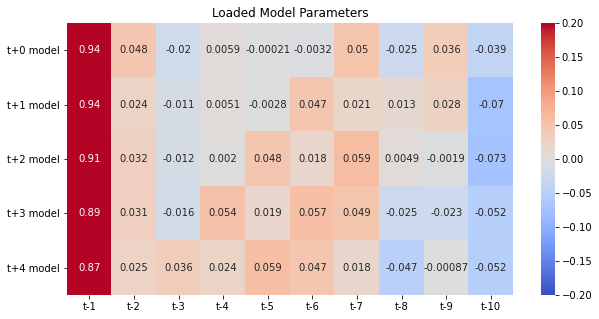

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.heatmap(param_df, annot=True, center=0, vmin=-0.2, vmax=0.2, cmap='coolwarm')
plt.yticks(rotation=0)
plt.title('Loaded Model Parameters')
plt.show()

In [153]:
print("Today's price:")
print(f'${x.iat[-1,0]:.2f}')

Today's price:
$60084.90


In [154]:
print('\nToday\'s prediction and future forecast:')
for model in loaded_models:
    print(f'${model.predict(x.iloc[-1:])[0]:.2f}')


Today's prediction and future forecast:
$60068.71
$60058.47
$60048.61
$60035.93
$60025.48


In [24]:
def ilinechart2(df, x, y, groups=None, title=""):
    fig = px.line(df, x=x, y=y, color=groups, title=title, template="none")
    
    #if groups != None:
    #    for item in range(len(fig.data)):
    #        fig.data[item].update(name=fig.data[item]['name'].split('=')[1])
    fig.show()

In [15]:
ilinechart2(btc5min_data, x='time', y='close')

In [19]:
btc5min_data['20_day'] = btc5min_data['close'].rolling(window=20).mean()
btc5min_data['50_day'] = btc5min_data['close'].rolling(window=50).mean()
btc5min_data['100_day'] = btc5min_data['close'].rolling(window=100).mean()
btc5min_data['200_day'] = btc5min_data['close'].rolling(window=200).mean()
btc5min_data.head(1)

time      open      high       low     close      Volume  \
0 2021-03-30 13:00:00  59112.81  59265.18  59109.16  59141.89  263.902903   

    Volume MA     price  20_day  50_day  100_day  200_day  
0  234.711945  59112.81     NaN     NaN      NaN      NaN

In [21]:
melted = btc5min_data.melt(id_vars='time', value_vars=['close', '20_day', '50_day', '100_day', '200_day'])

melted.head()

time variable     value
0 2021-03-30 13:00:00    close  59141.89
1 2021-03-30 13:05:00    close  58955.53
2 2021-03-30 13:10:00    close  58902.11
3 2021-03-30 13:15:00    close  59010.35
4 2021-03-30 13:20:00    close  59081.89

In [25]:
ilinechart2(melted, x='time', y='value', groups='variable')

In [26]:
def wma(df, field, window):
    weights = np.arange(1, window + 1)
    ma = df[field].rolling(window)
    # raw just applies the function to a numpy array instead of series for performance
    wma = ma.apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma

In [27]:
np.arange(1, 10 + 1) /np.arange(1, 10 + 1).sum()

array([0.01818182, 0.03636364, 0.05454545, 0.07272727, 0.09090909,
       0.10909091, 0.12727273, 0.14545455, 0.16363636, 0.18181818])

In [31]:
btc5min_data['200_day_wma'] = wma(btc5min_data, 'close', window=200)

melted = btc5min_data.melt(
    id_vars='time', 
    value_vars=['close', '200_day', '200_day_wma']
)

ilinechart2(melted, x='time', y='value', groups='variable')

In [32]:
model1 = sm.tsa.ExponentialSmoothing(btc5min_data['close']).fit()
btc5min_data['Exp'] = model1.fittedvalues

melted = btc5min_data.melt(
    id_vars='time', 
    value_vars=['price', '20_day', 'Exp']
)

ilinechart2(melted, x='time', y='value', groups='variable')

/Users/python/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation



# ARIMA modeling

In [42]:
x_ar = [15]
for i in range(500):
    y = 5 + .7*x_ar[i-1] 
    x_ar.append(float(y))
    

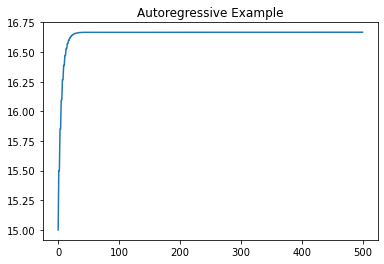

In [43]:
plt.plot(x_ar)
plt.title('Autoregressive Example')
plt.show()

In [44]:
bt_df=btc5min_data

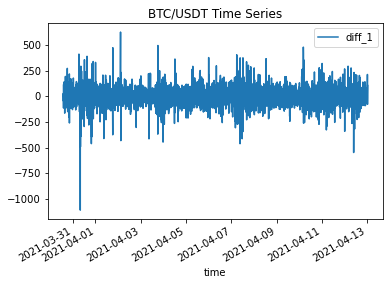

In [45]:
bt_df['diff_1'] = bt_df.price - bt_df.price.shift()
bt_df.plot(y='diff_1')
plt.title('BTC/USDT Time Series')
plt.show()

In [48]:
bt_df.head()


open      high       low     close      Volume  \
time                                                                      
2021-03-30 13:50:00  58899.99  58983.54  58822.02  58860.01  299.810111   
2021-03-30 13:55:00  58860.01  58930.08  58819.19  58890.01  347.944285   
2021-03-30 14:00:00  58890.01  58934.39  58751.00  58794.65  286.509064   
2021-03-30 14:05:00  58793.65  58796.97  58665.24  58679.71  284.102467   
2021-03-30 14:10:00  58679.70  58804.93  58626.92  58796.30  256.011551   

                      Volume MA     price       t-6       t-7       t-8  \
time                                                                      
2021-03-30 13:50:00  237.149405  58899.99  59010.36  58902.10  58955.53   
2021-03-30 13:55:00  246.090726  58860.01  59089.51  59010.36  58902.10   
2021-03-30 14:00:00  251.588955  58890.01  59095.74  59089.51  59010.36   
2021-03-30 14:05:00  254.913502  58793.65  58939.97  59095.74  59089.51   
2021-03-30 14:10:00  259.320929  58679.70  59010.14  58939.97  59095.74   

                          t-9      t-10  diff_1  
time                                             
2021-03-30 13:50:00  59141.90  59112.81     NaN  
2021-03-30 13:55:00  58955.53  59141.90  -39.98  
2021-03-30 14:00:00  58902.10  58955.53   30.00  
2021-03-30 14:05:00  59010.36  58902.10  -96.36  
2021-03-30 14:10:00  59089.51  59010.36 -113.95

In [50]:
from statsmodels.tsa.stattools import pacf

price=pd.DataFrame(columns= ['price'])

price['price']=bt_df['price']
#price['acf'] = pd.DataFrame(pacf(bt_df.price))
price.head(1)

price
time                         
2021-03-30 13:50:00  58899.99

Text(0.5, 1.0, 'BTC/USDT Price')

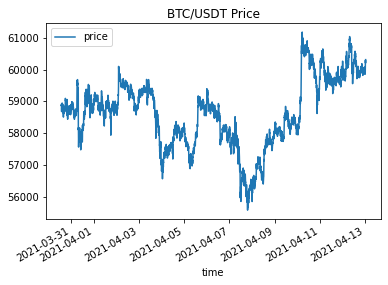

In [51]:
price.plot()
plt.title("BTC/USDT Price")

In [52]:
price.head(1)

price
time                         
2021-03-30 13:50:00  58899.99

# Converting series to stationary

In [53]:
 price_diff= (price.diff(periods=1))[1:]
 #integrated of order 1 denoted by d (for diff), one of the parameter of ARIMA model

In [54]:
price_diff.head()

price
time                       
2021-03-30 13:55:00  -39.98
2021-03-30 14:00:00   30.00
2021-03-30 14:05:00  -96.36
2021-03-30 14:10:00 -113.95
2021-03-30 14:15:00  116.60

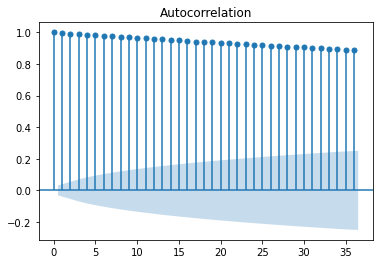

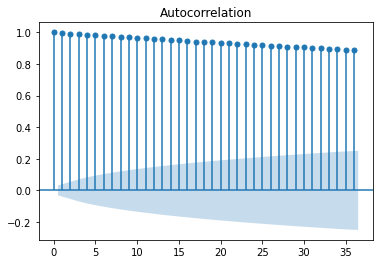

In [55]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(price)


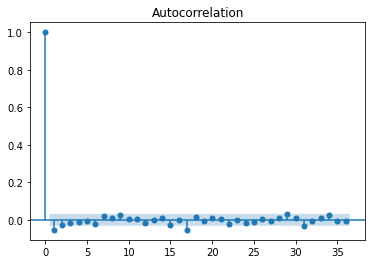

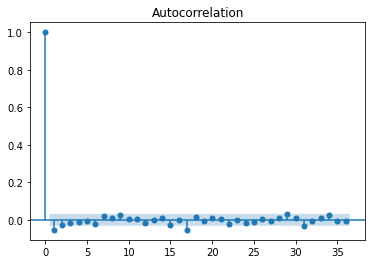

In [56]:
plot_acf(price_diff)

<AxesSubplot:xlabel='time'>

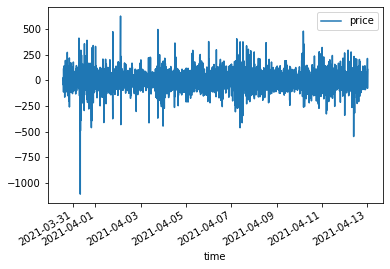

In [57]:
price_diff.plot()

/Users/python/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1016: FutureWarning:

The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.



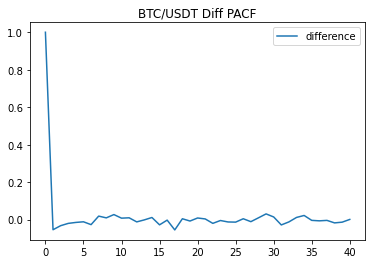

In [84]:
x_acf = pd.DataFrame(pacf(bt_df.diff_1[1:]))
x_acf.plot()
plt.title("BTC/USDT Diff PACF")
plt.legend(['difference'])

In [103]:
X = price.price
X.reset_index(inplace=True,drop=True)
brake=int(len(X)*0.75)
train = X[0:brake]
test = X[brake:]
print (f'{brake} train records.\n{len(X)-brake} Test records.\n\nTotal of {len(X)} records.')

2904 train records.
968 Test records.

Total of 3872 records.


In [104]:
print (train.tail(1))
print (test.head(1))
predictions = []

2903    58286.26
Name: price, dtype: float64
2904    58233.15
Name: price, dtype: float64


In [105]:
from statsmodels.tsa.ar_model import AutoReg as AR
from sklearn.metrics import mean_squared_error

model_ar = AR(train,lags=1)
model_ar_fit = model_ar.fit()

/Users/python/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



In [106]:
predictions = model_ar_fit.predict(start=970, end=3882)

In [112]:
#predictions=predictions.reset_index()
#test=test.reset_index()
print (predictions.size)
print (train.size)
print (train.head(1))
print (predictions.head(1))

2913
2904
0    58899.99
Name: price, dtype: float64
970    58809.865517
dtype: float64


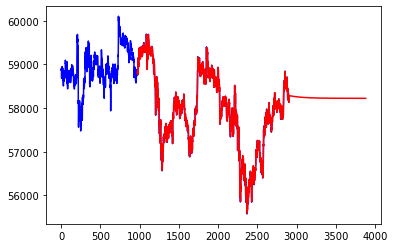

In [111]:

plt.plot(train, color = 'blue')
plt.plot(predictions, color='red')

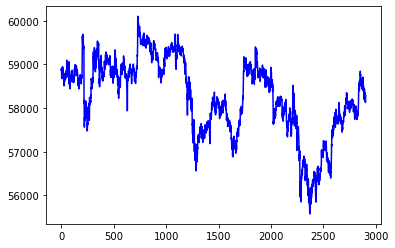

In [113]:
plt.plot(train, color = 'blue')

In [114]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bt_df.price, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 3871
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -23140.376
Method:                           css   S.D. of innovations             95.482
Date:                Thu, 15 Apr 2021   AIC                          46284.751
Time:                        13:29:52   BIC                          46297.274
Sample:                             1   HQIC                         46289.198
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3656      1.535      0.238      0.812      -2.642       3.374
Residuals Description
count    3.871000e+03
mean     1.991943e-14
std      9.549474e+01
min     -1.112266e+03
25%     -5.405563e+01

In [116]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(bt_df.price, order=(1,0,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

/Users/python/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/python/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will b

In [119]:
from statsmodels.tsa.arima_model import ARIMA
model_111 = ARIMA(bt_df.price, order=(1,1,1))
model_111_fit = model_111.fit()
print(model_111_fit.summary())
print('Residuals Description')
print(model_111_fit.resid.describe())

/Users/python/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


/Users/python/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will b

Text(0.5, 1.0, 'Histogram of Residuals')

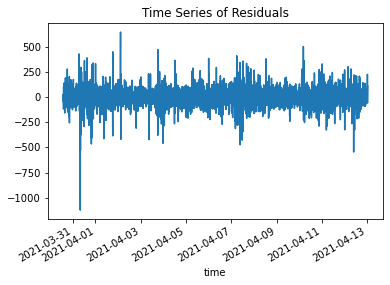

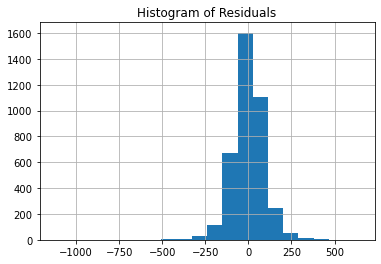

In [120]:
residuals = pd.DataFrame(model_111_fit.resid)

residuals.plot(legend=False)
plt.title('Time Series of Residuals')

residuals.hist(bins=20)
plt.title('Histogram of Residuals')